In [82]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv

--2025-10-07 06:40:32--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 874188 (854K) [text/plain]
Saving to: ‘car_fuel_efficiency.csv’

car_fuel_efficiency 100%[===================>] 853.70K  --.-KB/s    in 0.05s   

2025-10-07 06:40:32 (18.4 MB/s) - ‘car_fuel_efficiency.csv’ saved [874188/874188]



In [83]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

In [84]:
car_fuel_efficiency_df = pd.read_csv('car_fuel_efficiency.csv')
car_fuel_efficiency_df = car_fuel_efficiency_df[['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']]

car_fuel_efficiency_df.head(5)

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


In [85]:
len(car_fuel_efficiency_df)

9704

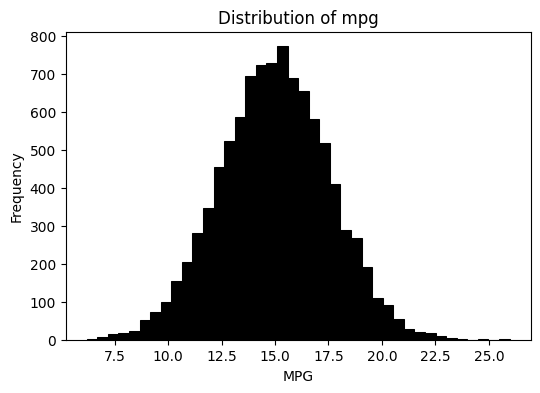

In [86]:

plt.figure(figsize=(6, 4))

sns.histplot(car_fuel_efficiency_df.fuel_efficiency_mpg, bins=40, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('MPG')
plt.title('Distribution of mpg')

plt.show()

**Question 1**

In [87]:
car_fuel_efficiency_df.isnull().sum()

,0
engine_displacement,0
horsepower,708
vehicle_weight,0
model_year,0
fuel_efficiency_mpg,0


**Question 2**

In [88]:
car_fuel_efficiency_df.horsepower.describe()

,horsepower
count,8996.000000
mean,149.657292
std,29.879555
min,37.000000
25%,130.000000
50%,149.000000
75%,170.000000
max,271.000000


**Question 3**

In [89]:
def prepare_datasets(full_df, seed=42):
  idx = np.arange(len(full_df))

  np.random.seed(seed)
  np.random.shuffle(idx)

  shuffled_full_df = full_df.iloc[idx]
  shuffled_full_df = shuffled_full_df.reset_index(drop=True)
  y_full = shuffled_full_df['fuel_efficiency_mpg']
  del shuffled_full_df['fuel_efficiency_mpg']

  n = len(shuffled_full_df)
  n_val = int(n * 0.2)
  n_test = int(n * 0.2)
  n_train = n - n_val - n_test

  df_train = shuffled_full_df.iloc[:n_train]
  df_val = shuffled_full_df.iloc[n_train:n_train+n_val]
  df_test = shuffled_full_df.iloc[n_train+n_val:]

  y_train = y_full.iloc[idx[:n_train]]
  y_val = y_full.iloc[idx[n_train:n_train+n_val]]
  y_test = y_full.iloc[idx[n_train+n_val:]]

  result = {
      "train": (df_train, y_train),
      "validation": (df_val, y_val),
      "test": (df_test, y_test),
  }

  return result



In [90]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

In [91]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [92]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

In [93]:
# Calculate the mean of train_df
all_raw_datasets = prepare_datasets(car_fuel_efficiency_df)
train_df = all_raw_datasets['train'][0]
mean_horsepower = train_df["horsepower"].mean()

filled_with_0 = train_df.fillna(0)
filled_with_mean = train_df.fillna(mean_horsepower)


In [94]:
w0, w = train_linear_regression(filled_with_0, all_raw_datasets['train'][1])

print(w0)

y_pred = w0 + all_raw_datasets['validation'][0].dot(w)
rmse(all_raw_datasets['validation'][1], y_pred).round(2)

10.858125472251395


np.float64(2.45)

In [95]:
w0, w = train_linear_regression(filled_with_mean, all_raw_datasets['train'][1])

print(w0)

y_pred = w0 + all_raw_datasets['validation'][0].dot(w)
rmse(all_raw_datasets['validation'][1], y_pred).round(2)

10.866686035577596


np.float64(2.45)

Answer: Both are equally good

**Question 4**

In [96]:
datasets = prepare_datasets(car_fuel_efficiency_df)
train_df = datasets["train"][0].fillna(0)

results = {}

for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
  w0, w = train_linear_regression_reg(train_df, datasets["train"][1], r)
  y_pred = w0 + datasets['validation'][0].dot(w)
  current_rmse = rmse(datasets['validation'][1], y_pred)

  results[r] = current_rmse.round(2)

results

{0: np.float64(2.45),
 0.01: np.float64(2.45),
 0.1: np.float64(2.45),
 1: np.float64(2.45),
 5: np.float64(2.45),
 10: np.float64(2.45),
 100: np.float64(2.45)}

Answer: 0

**Question 5**

In [97]:
results = {}

for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
  datasets = prepare_datasets(car_fuel_efficiency_df, seed)
  train_df = datasets["train"][0].fillna(0)

  w0, w = train_linear_regression(train_df, datasets["train"][1])
  y_pred = w0 + datasets['validation'][0].dot(w)
  current_rmse = rmse(datasets['validation'][1], y_pred)

  results[seed] = current_rmse

all_rmse = list(results.values())
deviation = np.std(all_rmse)

round(deviation, 3)




np.float64(0.087)

Answer: 0.06

**Question 6:**

In [98]:
datasets = prepare_datasets(car_fuel_efficiency_df, 9)

train_validation_df = pd.concat([datasets["train"][0], datasets["validation"][0]])
train_validation_df = train_validation_df.fillna(0)

train_validation_y = np.concatenate([datasets["train"][1], datasets["validation"][1]])

w0, w = train_linear_regression_reg(train_validation_df, train_validation_y, 0.001)
y_pred = w0 + datasets['test'][0].dot(w)

rmse(datasets['test'][1], y_pred)




np.float64(2.589344407518844)